In [11]:
import sys
sys.path.append('../')

from scipy import *
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib.animation
import PlanktonSignaling.basics as PS
from PlanktonSignaling.plotTools import plotScene,buildMovie
import profile

%matplotlib notebook


In [5]:
def constantDep(c,depMaxStr,**kwargs):
    '''Constant deposition function'''
    return(array(depMaxStr*ones(len(c))))

def atanDep(c,depMaxStr,depThreshold=0.08,depTransWidth=1/250,**kwargs):
    '''arctan (soft switch) transition function'''

    return(depMaxStr/pi*(arctan((-c+depThreshold)/depTransWidth)+pi/2))

def linAtanDep(c,depMaxStr,depThreshold=0.08,depTransWidth=1/250,**kwargs):
    '''arctan (soft switch) transition function'''

    return(depMaxStr/pi*(c+0.1*depThreshold)/1.1/depThreshold*(arctan((-c+depThreshold)/depTransWidth)+pi/2))


# RT swimmers in a background field

Set up some basic initial conditions.

**Caution:** All length scales should be roughly the same or something is going to be underresolved.

In [6]:
meshsize = 40
print('Mesh length scale: {0:8.2e}'.format(1/meshsize))
Swimmers = PS.Plankton(atanDep,N = meshsize,depMaxStr=1.0e-4,depVar=4.0e-4,k=0.02,speed=0.05,
                    lambda0=1.0,kappa=6.4e-3,beta=0.25,depTransWidth=0.001,depThreshold=0.08)

def initial_conditions(x,y):
    return(0*x)

Swimmers.SetBeta(1.0)


Mesh length scale: 2.50e-02
Exact deposition variance: 1.28e-04, length scale: 1.13e-02.  a2: 4.00e-04.


In [7]:
meshsize = 40
print('Mesh length scale: {0:8.2e}'.format(1/meshsize))
Swimmers = PS.Plankton(linAtanDep,N = meshsize,depMaxStr=2.0e-4,depVar=4.0e-4,k=0.02,speed=0.05,
                    lambda0=1.0,kappa=6.4e-3,beta=0.25,depTransWidth=0.001,depThreshold=0.08)

def initial_conditions(x,y):
    return(0*x)

Swimmers.SetBeta(1.0)


Mesh length scale: 2.50e-02
Exact deposition variance: 1.28e-04, length scale: 1.13e-02.  a2: 4.00e-04.


Initialize the scalar field.  Lay out some particles.

<IPython.core.display.Javascript object>


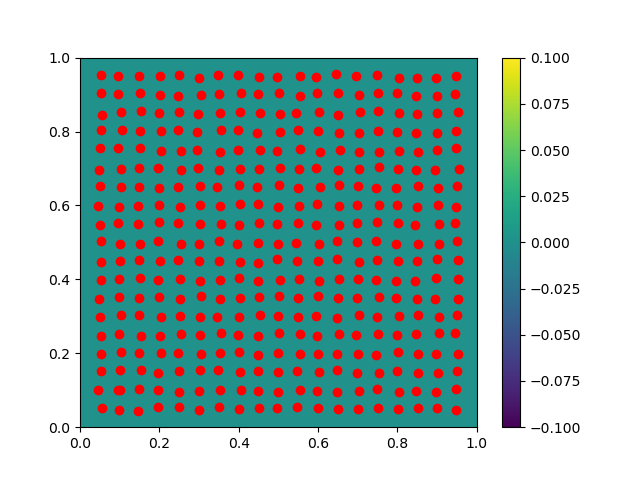

In [8]:
Swimmers.SetIC(initial_conditions)

pos = [array([0.1,0.1])]
th = rand()*2*pi
vel = [Swimmers.speed*array([cos(th),sin(th)])]
for l in range(0,19):
    for k in range(0,19):
        pos = np.append(pos,[array([k*0.05 + 0.01*(rand()-0.5) + 0.05,
                                  l*0.05 + 0.01*(rand()-0.5) + 0.05])],axis=0)
        th  = rand()*2*pi
        vel = np.append(vel,[Swimmers.speed*array([cos(th),sin(th)])],axis=0)

plt.figure()
plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
plt.plot(pos[:,0],pos[:,1],'ro')
plt.colorbar()
plt.show()

Simulate the system.  The upper value of the inner loop can be adjusted as needed.  The inner value of 1000 is a pretty long simulation.

In [ ]:
pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,200):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

Another sim varying $\lambda_0$.

<IPython.core.display.Javascript object>


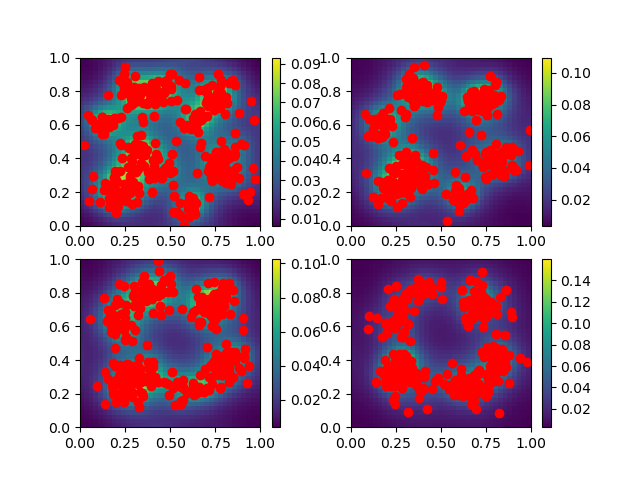

In [9]:
Swimmers.lambda0 = 3.0

pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,500):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plotScene(Swimmers,pos)

plt.show()

In [ ]:
Swimmers.lambda0 = 10.0

pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,1000):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

### Animation

This routine animates the particle position and scalar field data.
Honestly, I still do not completely understand why this works and other things that I tried did not work.  Be careful about returning axis objects with or without a comma.  It seems to cause a problem sometimes one way and sometimes the other (**"return field"** not "return field,"; but **"return dots,"** not "return dots").

<IPython.core.display.Javascript object>


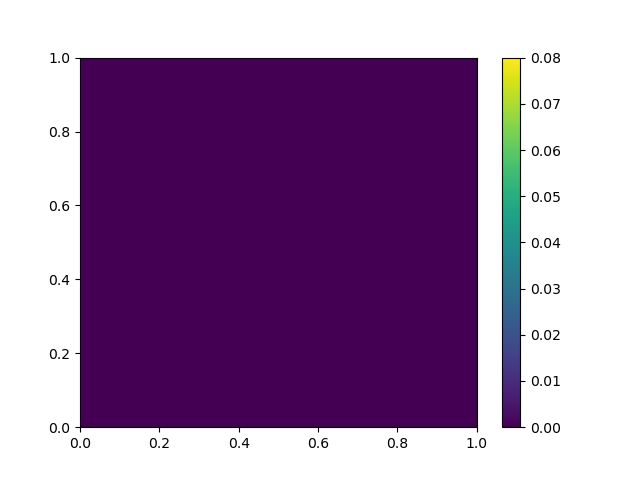

In [12]:
anim = buildMovie(Swimmers,scalar_store)

<IPython.core.display.Javascript object>


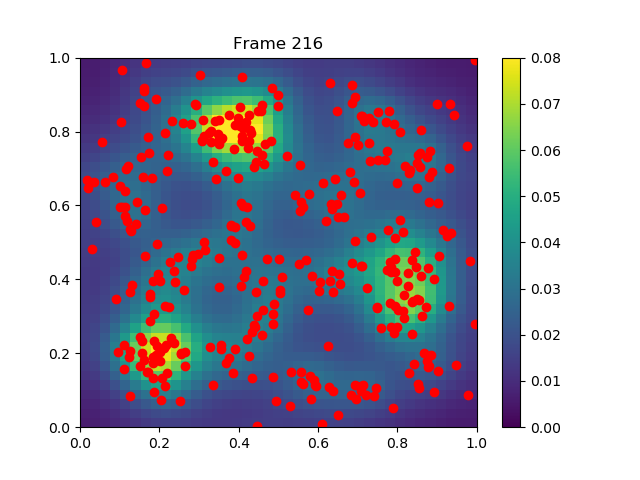

In [13]:
fig   = plt.figure()
ax    = plt.subplot(1,1,1)
field = ax.pcolormesh(Swimmers.xm,Swimmers.ym,scalar_store[1])
field.set_clim(0,0.08)
dots, = ax.plot([], [], 'ro')
fig.colorbar(field)

def initit():
    dots.set_data([], [])
    return field,dots

def animate(k):
    arr = scalar_store[k]
    arr = arr[:-1, :-1]
    field.set_array(arr.ravel())
    plt.title('Frame {0:d}'.format(k))
    dots.set_data(pos_store[k][:,0],pos_store[k][:,1])

    return field,dots,
    
anim = matplotlib.animation.FuncAnimation(fig,animate,frames=range(0,len(scalar_store),2),
                                          interval=50,blit=False,repeat=True)

# Uncomment if you want to save it to a file.  Requires mencoder or ffmpeg or some writer utility to generate the file.
anim.save('basic_animation.mp4', writer='ffmpeg')
plt.show()


### Simple animation

This routine animates the particle position data.


In [ ]:
fig   = plt.figure()
ax    = plt.axes(xlim=(0, 1), ylim=(0, 1))
dots, = ax.plot([], [], 'ro')

def initit():
    dots.set_data([], [])
    return dots,

def animate(k):
    dots.set_data(pos_store[k][:,0],pos_store[k][:,1])
    return dots,
    
anim = matplotlib.animation.FuncAnimation(fig, animate,init_func=initit,
                               frames=len(pos_store), interval=50, blit=True, repeat=True)

#anim.save('basic_animation.mp4', writer='mencoder')
plt.show()
